# LowProFool
## Adversarial examples generation on the german credit dataset

### Imports

In [158]:
# Misc
import random
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook
import math
import os
import time
import sys

In [159]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [161]:
# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Keras 
import keras

In [162]:
# Helpers
from Adverse import lowProFool, deepfool
from Metrics import *

### Notebook config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


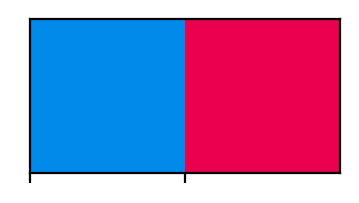

In [163]:
# Retina display
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_columns', 500)
tqdm.pandas()
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

ccolors = ["#008ae9", "#ea004f"]
sns.set_palette(ccolors)
sns.palplot(sns.color_palette())

### Constants

In [164]:
SEED = 0
DATASET = 'credit-g'

### Fetch data from openml

In [165]:
def get_df(dataset):
    assert dataset == 'credit-g', "This function is specifically for the credit-g dataset"
    
    dataset = fetch_openml(dataset, as_frame=True)
    df = dataset.data
    df['target'] = dataset.target

    # Renaming target for training later
    df['target'] = df['target'].map({'bad': 0.0, 'good': 1.0})

    # Subsetting features to keep only continuous, discrete and ordered categorical
    feature_names = ['checking_status', 'duration', 'credit_amount',
                     'savings_status', 'employment', 'installment_commitment',
                     'residence_since', 'age', 'existing_credits', 'num_dependents',
                     'own_telephone', 'foreign_worker']

    df = df[feature_names + ['target']]

    # Convert categorical variables to numeric
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.Categorical(df[col]).codes

    return df, 'target', feature_names

### Preprocess data

In [166]:
def get_weights(df, target, show_heatmap=False):
    if target not in df.columns:
        raise ValueError(f"Column '{target}' not found in dataframe. Available columns: {df.columns}")

    def heatmap(cor):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

    cor = df.corr()
    cor_target = abs(cor[target])

    weights = cor_target[cor_target.index != target]
    weights = weights / np.linalg.norm(weights)

    if show_heatmap:
        heatmap(cor)
            
    return weights.values

def balance_df(df, target):
    len_df_0, len_df_1 = len(df[df[target] == 0]), len(df[df[target] == 1])
    min_samples = min(len_df_0, len_df_1)
    df_0 = df[df[target] == 0].sample(min_samples, random_state=SEED)
    df_1 = df[df[target] == 1].sample(min_samples, random_state=SEED)
    return pd.concat((df_0, df_1))

def get_bounds(df, feature_names):
    return [df[feature_names].min().values, df[feature_names].max().values]
# def get_bounds():
#     low_bounds = df_orig.min().values
#     up_bounds = df_orig.max().values
    
#     #removing target WARNING ASSUMES TARGET IS LAST
#     low_bounds = low_bounds[:-1]
#     up_bounds = up_bounds[:-1]
    
#     return [low_bounds, up_bounds]

def split_train_test_valid(df, test_size=300, valid_size=50):
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=True, random_state=SEED)
    df_test, df_valid = train_test_split(df_test, test_size=valid_size, shuffle=True, random_state=SEED)
    return df_train, df_test, df_valid

### Normalize関数

In [167]:
def normalize(df, target, feature_names, bounds):
    # print("Input bounds:", bounds)
    # print("Feature names:", feature_names)
    
    # boundsがリスト形式の場合の処理
    if isinstance(bounds, list) and len(bounds) == 2:
        min_bounds, max_bounds = bounds
        numeric_features = [f for f in feature_names if pd.api.types.is_numeric_dtype(df[f])]
        bounds_dict = {
            feature: {'type': 'numeric', 'min': min_val, 'max': max_val}
            for feature, min_val, max_val in zip(numeric_features, min_bounds, max_bounds)
        }
        # カテゴリカル特徴量に対するboundsを追加
        for feature in feature_names:
            if feature not in bounds_dict:
                bounds_dict[feature] = {'type': 'categorical', 'values': df[feature].unique().tolist()}
    else:
        bounds_dict = bounds  # 既存の辞書形式の場合
    
    # print("Bounds dict:", bounds_dict)

    # 数値特徴量とカテゴリカル特徴量を分離
    numeric_features = [f for f in feature_names if pd.api.types.is_numeric_dtype(df[f])]
    categorical_features = [f for f in feature_names if f not in numeric_features]

    # print("Numeric features:", numeric_features)
    print("Categorical features:", categorical_features)

    # スケーリング
    scaler = StandardScaler()
    if numeric_features:
        df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # boundsの更新
    scaled_bounds = {}
    if numeric_features:
        original_mins = pd.DataFrame({f: [bounds_dict[f]['min']] for f in numeric_features})
        original_maxs = pd.DataFrame({f: [bounds_dict[f]['max']] for f in numeric_features})
        scaled_mins = scaler.transform(original_mins)
        scaled_maxs = scaler.transform(original_maxs)
        
        for feature, scaled_min, scaled_max in zip(numeric_features, scaled_mins[0], scaled_maxs[0]):
            scaled_bounds[feature] = {'type': 'numeric', 'min': scaled_min, 'max': scaled_max}

    # カテゴリカル特徴量の処理（ここではそのまま保持）
    for feature in categorical_features:
        scaled_bounds[feature] = bounds_dict[feature]

    return scaler, df, scaled_bounds

### Training neural net

In [168]:
def get_model(conf, load=False):
    assert(conf['Dataset'] == 'credit-g')
    
    class GermanNet(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(GermanNet, self).__init__()
            self.linear1 = torch.nn.Linear(D_in, H)
            self.linear2 = torch.nn.Linear(H, H)
            self.linear3 = torch.nn.Linear(H, D_out)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=0)

        def forward(self, x):
            h1 = self.relu(self.linear1(x))
            h2 = self.relu(self.linear2(h1))
            h3 = self.relu(self.linear2(h2))
            h4 = self.relu(self.linear2(h3))
            h5 = self.relu(self.linear2(h4))
            h6 = self.relu(self.linear2(h5))
            a3 = self.linear3(h6)
            y = self.softmax(a3)
            return y

    def train(model, criterion, optimizer, X, y, N, n_classes):
        model.train()

        current_loss = 0
        current_correct = 0


        # Training in batches
        for ind in range(0, X.size(0), N):
            indices = range(ind, min(ind + N, X.size(0)) - 1) 
            inputs, labels = X[indices], y[indices]
            inputs = Variable(inputs, requires_grad=True)


            optimizer.zero_grad()

            output = model(inputs)
            _, indices = torch.max(output, 1) # argmax of output [[0.61, 0.12]] -> [0]
            # [[0, 1, 1, 0, 1, 0, 0]] -> [[1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
            preds = torch.tensor(keras.utils.to_categorical(indices, num_classes=n_classes))

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            current_correct += (preds.int() == labels.int()).sum() /n_classes


        current_loss = current_loss / X.size(0)
        current_correct = current_correct.double() / X.size(0)    

        return preds, current_loss, current_correct.item()
    
    df = conf['TrainData']
    target = conf['Target']
    feature_names = conf['FeatureNames']
                        
    n_classes = len(np.unique(df[target]))
    X_train = torch.FloatTensor(df[feature_names].values)
    y_train = keras.utils.to_categorical(df[target], n_classes)
    y_train = torch.FloatTensor(y_train)

    D_in = X_train.size(1)
    D_out = y_train.size(1)

    epochs = 400
    batch_size = 100
    H = 100
    net = GermanNet(D_in, H, D_out)

    lr = 1e-4    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        preds, epoch_loss, epoch_acc = train(net, criterion, optimizer, X_train, y_train, batch_size, n_classes)     
        if (epoch % 50 == 0):
            print("> epoch {:.0f}\tLoss {:.5f}\tAcc {:.5f}".format(epoch, epoch_loss, epoch_acc))

    net.eval()
    
    return net

### Generate adversarial examples

In [169]:
def gen_adv(config, method):
    df_test = config['TestData']
    extra_cols = ['orig_pred', 'adv_pred', 'iters']    
    model = config['Model']
    weights = config['Weights']
    bounds = config['Bounds']
    maxiters = config['MaxIters']
    alpha = config['Alpha']
    lambda_ = config['Lambda']
    
    results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
            
    i = -1
    for _, row in tqdm_notebook(df_test.iterrows(), total=df_test.shape[0], desc="{}".format(method)):
        i += 1
        x_tensor = torch.FloatTensor(row[config['FeatureNames']])   
        
        if method == 'LowProFool':
            orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, bounds,
                                                             maxiters, alpha, lambda_)
        elif method == 'Deepfool':
            orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, maxiters, alpha,
                                                          bounds, weights=[])
        else:
            raise Exception("Invalid method", method)
        results[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
        
    return pd.DataFrame(results, index=df_test.index, columns = feature_names + extra_cols)

In [170]:
# Load initial dataset
df_orig, target, feature_names = get_df(DATASET)

# Balance dataset classes
df = balance_df(df_orig, target)

# 1. 正しい関数定義
def get_bounds(df, feature_names):
    """
    Calculate the bounds for given features in a dataframe, handling both numeric and categorical variables.
    
    Args:
        df (pd.DataFrame): Input dataframe
        feature_names (list): List of feature names to calculate bounds for
    
    Returns:
        dict: Dictionary containing bounds for numeric features and unique values for categorical features
    """
    bounds = {}
    
    for feature in feature_names:
        if feature not in df.columns:
            print(f"Warning: Feature '{feature}' not found in the dataframe.")
            continue
        
        if pd.api.types.is_numeric_dtype(df[feature]):
            bounds[feature] = {
                'type': 'numeric',
                'min': df[feature].min(),
                'max': df[feature].max()
            }
        else:
            bounds[feature] = {
                'type': 'categorical',
                'values': df[feature].unique().tolist()
            }
    
    return bounds

# 2. 関数の呼び出し
bounds = get_bounds(df_orig, feature_names)

# 3. デバッグ用の関数
def debug_get_bounds():
    print("Current definition of get_bounds:")
    print(get_bounds.__code__.co_varnames)
    print("Number of arguments:", get_bounds.__code__.co_argcount)

# デバッグ関数の呼び出し
debug_get_bounds()

# 4. エラーハンドリングを追加した版
def get_bounds_safe(df, feature_names):
    try:
        return [df[feature_names].min().values, df[feature_names].max().values]
    except Exception as e:
        print(f"Error in get_bounds: {e}")
        print(f"DataFrame columns: {df.columns}")
        print(f"Requested features: {feature_names}")
        return None

# 安全版の関数の呼び出し
bounds = get_bounds_safe(df_orig, feature_names)

Current definition of get_bounds:
('df', 'feature_names', 'bounds', 'feature')
Number of arguments: 2


/opt/conda/envs/lowprofool/lib/python3.7/site-packages/sklearn/datasets/_openml.py:421: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]["version"])
/opt/conda/envs/lowprofool/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [174]:
# Load initial dataset
df_orig, target, feature_names = get_df(DATASET)

# Balance dataset classes
df = balance_df(df_orig, target)

# Compute the bounds for clipping
bounds = get_bounds(df_orig, feature_names)

# Normalize the data
scaler, df, bounds = normalize(df, target, feature_names, bounds)

# デバッグ
print("Target value:", target)
print("DataFrame columns:", df.columns)
print("Is target in columns:", target in df.columns)
df['target'] = df['target'].astype(float)
print(df['target'].dtype)
print(df['target'].value_counts())
# Compute the weihts modelizing the expert's knowledge
try:
    weights = get_weights(df, target)
except Exception as e:
    print(f"Error in get_weights: {e}")
    print(f"DataFrame columns: {df.columns}")
    print(f"Target column: {target}")
    raise

# デバッグ用
print("DataFrame shape:", df.shape)
print("DataFrame columns:", df.columns)

# Split df into train/test/valid
# df_train, df_test, df_valid = split_train_test_valid()

categorical_features = ['checking_status', 'savings_status', 'employment', 'own_telephone', 'foreign_worker']
df_encoded = pd.get_dummies(df, columns=categorical_features)

print("Encoded DataFrame shape:", df_encoded.shape)
print("Encoded DataFrame columns:", df_encoded.columns)

# データの分割
df_train_encoded, df_test_encoded, df_valid_encoded = split_train_test_valid(df_encoded)

print("Encoded Train set shape:", df_train_encoded.shape)
print("Encoded Test set shape:", df_test_encoded.shape)
print("Encoded Validation set shape:", df_valid_encoded.shape)

# 分割後のデータセットのサイズを確認
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_valid.shape)

# 各セットのターゲット変数の分布を確認
print("\nTarget distribution in train set:")
print(df_train['target'].value_counts(normalize=True))
print("\nTarget distribution in test set:")
print(df_test['target'].value_counts(normalize=True))
print("\nTarget distribution in validation set:")
print(df_valid['target'].value_counts(normalize=True))# データの分割
df_train, df_test, df_valid = split_train_test_valid(df)

# 分割後のデータセットのサイズを確認
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_valid.shape)

# 各セットのターゲット変数の分布を確認
print("\nTarget distribution in train set:")
print(df_train['target'].value_counts(normalize=True))
print("\nTarget distribution in test set:")
print(df_test['target'].value_counts(normalize=True))
print("\nTarget distribution in validation set:")
print(df_valid['target'].value_counts(normalize=True))

# Build experimenation config
config = {'Dataset'     : 'credit-g',
         'MaxIters'     : 20000,
         'Alpha'        : 0.001,
         'Lambda'       : 8.5,
         'TrainData'    : df_train,
         'TestData'     : df_test,
         'ValidData'    : df_valid,
         'Scaler'       : scaler,
         'FeatureNames' : feature_names,
         'Target'       : target,
         'Weights'      : weights,
         'Bounds'       : bounds}

# Train neural network
model = get_model(config)
config['Model'] = model

# Compute accuracy on test set
y_true = df_test[target]
x_test = torch.FloatTensor(df_test[feature_names].values)
y_pred = model(x_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
print("Accuracy score on test data", accuracy_score(y_true, y_pred))
    
# Sub sample
config['TestData'] = config['TestData'].sample(n=10, random_state = SEED)

# Generate adversarial examples
df_adv_lpf = gen_adv(config, 'LowProFool')
df_adv_df = gen_adv(config, 'Deepfool')
config['AdvData'] = {'LowProFool' : df_adv_lpf, 'Deepfool' : df_adv_df}

# Compute metrics
list_metrics = {'SuccessRate' : True,
                'iter_means': False,
                'iter_std': False,
                'normdelta_median': False,
                'normdelta_mean': True,
                'n_std': True,
                'weighted_median': False,
                'weighted_mean': True,
                'w_std': True,
                'mean_dists_at_org': False,
                'median_dists_at_org': False,
                'mean_dists_at_tgt': False,
                'mean_dists_at_org_weighted': True,
                'mdow_std': True,
                'median_dists_at_org_weighted': False,
                'mean_dists_at_tgt_weighted': True,
                'mdtw_std': True,
                'prop_same_class_arg_org': False,
                'prop_same_class_arg_adv': False}

all_metrics = get_metrics(config, list_metrics)
all_metrics = pd.DataFrame(all_metrics, columns=['Method'] + [k for k, v in list_metrics.items() if v])
all_metrics

Categorical features: ['checking_status', 'savings_status', 'employment', 'own_telephone', 'foreign_worker']
Target value: target
DataFrame columns: Index(['checking_status', 'duration', 'credit_amount', 'savings_status',
       'employment', 'installment_commitment', 'residence_since', 'age',
       'existing_credits', 'num_dependents', 'own_telephone', 'foreign_worker',
       'target'],
      dtype='object')
Is target in columns: True
float64
0.0    300
1.0    300
Name: target, dtype: int64
DataFrame shape: (600, 13)
DataFrame columns: Index(['checking_status', 'duration', 'credit_amount', 'savings_status',
       'employment', 'installment_commitment', 'residence_since', 'age',
       'existing_credits', 'num_dependents', 'own_telephone', 'foreign_worker',
       'target'],
      dtype='object')
Encoded DataFrame shape: (600, 26)
Encoded DataFrame columns: Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_depende

/opt/conda/envs/lowprofool/lib/python3.7/site-packages/sklearn/datasets/_openml.py:421: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]["version"])


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
plot_ratios = []

m_lpf = all_metrics[all_metrics.Method == 'LowProFool']
m_df = all_metrics[all_metrics.Method =='Deepfool']

sr = m_lpf.SuccessRate.values / m_df.SuccessRate.values 
wm =  m_lpf.weighted_mean.values / m_df.weighted_mean.values 

plot_ratios.append([100*sr[0], 100*wm[0]])
plot_ratios = pd.DataFrame(plot_ratios, columns=['Success Rate Ratio', 'Mean Perturbation Ratio'])
plot_ratios['Dataset'] = 'German Credit'

f = plt.figure()
ax = plt.axes()
plot_ratios.plot(x='Dataset', kind='bar', legend=True, ax=ax)

for i, v in enumerate(plot_ratios['Success Rate Ratio'].values):
    ax.text(i - 0.2, v - 12 , str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')
for i, v in enumerate(plot_ratios['Mean Perturbation Ratio'].values):
    ax.text(i + 0.062, v - 12, str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
ax.axhline(100, ls=':', c='grey')
ax.text(-0.49, 100 - 5, '100%')


ax.set_yticks([])
plt.tight_layout()
plt.show()

NameError: name 'all_metrics' is not defined